Impulse: 9200.1080053


'Completed 30 iterations successfully. Total CPU time: 0.140625 s. Total wall time: 51.28823637962341 s'

Number of simulations:  30

FIN POSITION: 2.55

Out Of Rail Stability Margin -         Mean Value: 2.311 
Out Of Rail Stability Margin - Standard Deviation: 0.098 m
PROBABILITY THE Out Of Rail Stability Margin IS IN BETWEEN 1.5 AND 4 IS: 100.0%
There is a 90% chance that the mean of the Out Of Rail Stability Margin falls within THIS RANGE: 2.2814836757946075, 2.340216830216894



Apogee Altitude -         Mean Value: 2744.712 
Apogee Altitude - Standard Deviation: 91.621 m


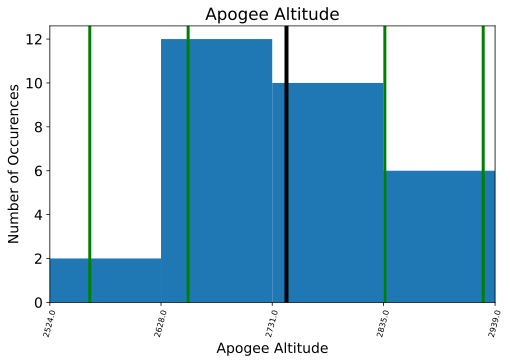

PROBABILITY THE Apogee Altitude IS IN BETWEEN 2895.6 AND 3200.4 IS: 4.98%
There is a 90% chance that the mean of the Apogee Altitude falls within THIS RANGE: 2717.197318761319, 2772.2262121403787

We have the hypothesis that our mean is greater than or equal to 3048. With our critical percent, our critical value is -1.6448536269514729. Then, our test statistic is -18.131011618696753
Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is 3048.




----------------------------------------------------------------------------------------------------



Simulated Landing Position x = 2687.743919415945, y = 1959.0485264186295


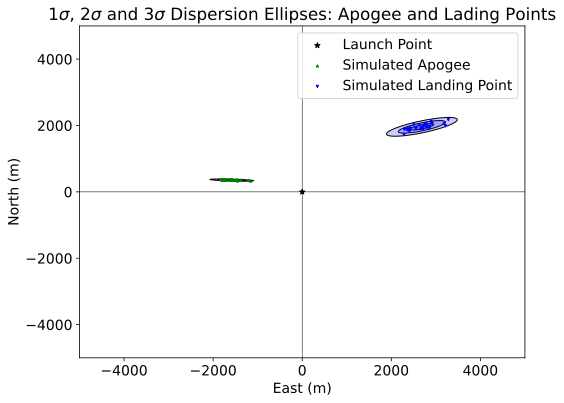

'Starting'

In [ ]:
from time import process_time, time
from rocketpy import Environment, SolidMotor, Rocket, Flight
import concurrent.futures
from ConcurrentFunctions import runFlightWithMonteCarlo
from rocketpy.motors import motor
from IPython.display import display
from scipy.stats import norm
from rocketpy.mathutils.function import Function
from rocketpy.environment import environment

%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14

import numpy as np

import logging

# Iterate the loop to read the cell values

dryMotorMass = 4.3367
grainInner =(43.942*10**-3)/2
grainOuter =(82.27*10**-3)/2
grainHeight = 0.1524
numGrain = 5
totalHeight = grainHeight*numGrain
centralAxis = (0.08333)*dryMotorMass*(grainOuter)**2
centralDiameter = ((1/4)*dryMotorMass*(grainOuter)**2) + (1/12)*dryMotorMass*(totalHeight)**2
the_nozzle_radius = (79.32*10**-3)/2
the_throat_radius= (29.21*10**-3)/2
the_nozzle_position = grainHeight*3.8
density = dryMotorMass / (((np.pi*grainOuter**2)-(np.pi*grainInner**2))*totalHeight)

# M1850W.all_info()

spMass = 16.4
spRadius = 0.155/2
spLength = .152 + .305 + .559 + .508 + .356 + .152

spCentralAxis = (spRadius**2)*spMass*2/12
spCentralDiameter = ((1/4)*spMass*(spRadius)**2) + (1/12)*spMass*(totalHeight)**2
the_center_of_mass_without_motor = 1.87

nose_cone_length = .813
the_fin_position = 2.62
boattailPos = 0.813+0.152+0.305+0.559+0.508+0.356+0.152
the_motor_position = spLength + nose_cone_length + grainHeight/2 - (totalHeight)/2
topRB = 2.79-0.274*2
drogueRadius = 0.61/2
drogueCdS = 0.97*3.1415*(drogueRadius)**2
lightRadius = 3.05/2
lightCdS = 2.2*3.1415*(lightRadius)**2


# In Fahrenheit
meanTemp = 80

envParams = {
    "latitude": 32.9823279,
    "longitude": -106.9490122,
    "elevation": 1400.556,
    "type": "custom_atmosphere",
}
env = Environment(latitude=envParams["latitude"], longitude=envParams["longitude"], elevation=envParams["elevation"],)

# Things to do: find out if rocket_center_of_dry_mass_position will be relative to rocket or not. IT IS.
the_motor_center_of_dry_mass_position = the_motor_position

burn_time = 2.505

_, _, points = motor.Motor.import_eng("thrustcurve.csv")
thrust_source = points
interpolation_method = "linear"
thrust = Function(thrust_source, "Time (s)", "Thrust (N)", interpolation_method, "zero")
impulse = thrust.integral(0, 2.505)
print("Impulse: " + str(impulse))


rocket_center_of_dry_mass_position = (the_center_of_mass_without_motor * spMass + the_motor_center_of_dry_mass_position * dryMotorMass) / (dryMotorMass + spMass)

analysis_parameters = {
    # Rocket's dry mass without motor (kg) and its uncertainty (standard deviation)
    "rocket_mass": (spMass, 0.001),
    # Rocket's inertia moment perpendicular to its axis (kg*m^2)
    "rocket_inertia_11": (spCentralDiameter, 0.036),
    # Rocket's inertia moment relative to its axis (kg*m^2)
    "rocket_inertia_33": (spCentralAxis, 0.00001),
    # Motors's dry mass without propellant (kg) and its uncertainty (standard deviation)
    "motor_dry_mass": (dryMotorMass, 0.001),
    # Motor's dry inertia moment perpendicular to its axis (kg*m^2)
    "motor_inertia_11": (centralAxis, 0.016),
    # Motors's dry inertia moment relative to its axis (kg*m^2)
    "motor_inertia_33": (centralDiameter, 0.00001),
    # Distance between rocket's center of dry mass and motor's center of dry mass (m)

    # THIS is likely wrong, go back to check it

    "motor_dry_mass_position": (np.abs(the_motor_center_of_dry_mass_position - rocket_center_of_dry_mass_position), 0.001),
    # Motor total impulse (N*s)
    "impulse": (impulse, 25.3),
    # Motor burn out time (s)
    "burn_time": (burn_time, .3),
    # Motor's nozzle radius (m)
    "nozzle_radius": (the_nozzle_radius, 0.5 / 1000),
    # Motor's nozzle throat radius (m)
    "throat_radius": (the_throat_radius, 0.5 / 1000),
    # Motor's grain separation (axial distance between two grains) (m)
    "grain_separation": (0, 1 / 1000),
    # Motor's grain density (kg/m^3)
    "grain_density": (density, 20),
    # Motor's grain outer radius (m)
    "grain_outer_radius": (grainOuter, 0.3 / 1000),
    # Motor's grain inner radius (m)
    "grain_initial_inner_radius": (grainInner, 0.3 / 1000),
    # Motor's grain height (m)
    "grain_initial_height": (grainHeight, 1 / 1000),
    # Rocket's radius (kg*m^2)
    "radius": (spRadius, 0.001),
    # Distance between rocket's center of dry mass and nozzle exit plane (m) (negative)
    "nozzle_position": (rocket_center_of_dry_mass_position-(the_nozzle_position + the_motor_position), 0.001),
    # Distance between rocket's center of dry mass and and center of propellant mass (m) (negative)
    "grains_center_of_mass_position": (rocket_center_of_dry_mass_position-(the_motor_center_of_dry_mass_position + the_motor_position), 0.0001),

    # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "power_off_drag": (1, 0.05),
    # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "power_on_drag": (1, 0.05),
    # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    "nose_distance_to_CM": (rocket_center_of_dry_mass_position-nose_cone_length, 0.001),
    # Axial distance between rocket's center of dry mass and nearest point in its fin (m)
    "fin_distance_to_CM": (the_fin_position - rocket_center_of_dry_mass_position, 0.001),
    # Launch rail inclination angle relative to the horizontal plane (degrees)
    "inclination": (90, 1),
    # Launch rail heading relative to north (degrees)
    "heading": (90, 2),
    # Drag coefficient times reference area for the drogue chute (m^2)
    "cd_s_drogue": (drogueCdS, 0.02),
    # Drag coefficient times reference area for the light chute
    "cd_s_light": (lightCdS, 0.02),
    # Time delay between parachute ejection signal is detected and parachute is inflated (s)
    "lag_rec": (0, 0.2),
    # Time delay between sensor signal is received and ejection signal is fired (s)
    "lag_se": (0, 0.1),
    # temperature in kelvin
    "temperature": ((meanTemp - 32) * 5/9 + 273.15, 5),
    # atmospheric pressure in pascals
    "atmosphere_pressure": (env.pressure_ISA(envParams["elevation"]), 300),
}

# M1850W.all_info()

#sets up the ability to log inputs.
def setup_logging():
    class MyHandler(logging.FileHandler):
        def emit(self, record):
            super().emit(record)  # Call the superclass's emit method
            self.flush()  # Flush after each log message

    # Use your custom handler
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    handler = MyHandler('app.log', 'a')
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

def createDistributionPlot(dispersonResultArray, name, lowerProbBound, upperProbBound, maxDecimals, percentConfidence, hypothesis, unit, makeGraph):
    mean = np.mean(dispersonResultArray)
    deviation = np.std(dispersonResultArray)
    unitString = ""
    if(unit == "meters"):
        unitString = "m"
    print(
        f'{name} -         Mean Value: {mean:0.3f} ' + unitString
    )
    print(
        f'{name} - Standard Deviation: {deviation:0.3f} m' + unitString
    )

    if(makeGraph):

        minimum = np.min(dispersonResultArray)
        maximum = np.max(dispersonResultArray)
        theBins = list()

        #using scott's rule to find the number of bins
        binWidth = 3.5 * deviation / np.power(len(dispersonResultArray), 1/3)
        numBins = int(np.round((maximum-minimum)/binWidth))

        changeInZ = (maximum - minimum) / numBins
        #test add
        zIterator = minimum
        for iterator in range(numBins):
            theBins.append(zIterator)
            zIterator += changeInZ
        finalValue = np.ceil(zIterator * np.power(10, maxDecimals)) / np.power(10, maxDecimals)
        theBins.append(finalValue)
        plt.figure()
        plt.xlim(minimum, maximum)
        minTextSize = 8
        maxTickCount = 50
        xTickBins = theBins
        if(numBins > maxTickCount):
            xTickBins = list()
            changeInZ = (maximum - minimum) / 50.0
            zIterator = minimum
            for iterator in range(50):
                xTickBins.append(zIterator)
                zIterator += changeInZ
        binListToString = list()
        for currentBin in xTickBins:
            binListToString.append(str(round(currentBin, maxDecimals)))
        plt.xticks(ticks = xTickBins, labels = binListToString, rotation = 75, fontsize = minTextSize)
        plt.hist(dispersonResultArray, bins=theBins)
        plt.title(name)
        plt.xlabel(name)
        plt.ylabel("Number of Occurences")

        plt.axvline(mean, color='k', linestyle='solid', linewidth=4)
        plt.axvline(mean - deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean - 2*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean - 3*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + 2*deviation, color='g', linestyle='solid', linewidth=3)
        plt.axvline(mean + 3*deviation, color='g', linestyle='solid', linewidth=3)
        plt.show()
    lowerZ = (lowerProbBound - mean)/deviation
    upperZ = (upperProbBound - mean)/deviation
    probabilityInRange = norm.cdf(upperZ) - norm.cdf(lowerZ)
    print("PROBABILITY THE " + name +  " IS IN BETWEEN " + str(round(lowerProbBound, 4)) + " AND " + str(round(upperProbBound, 4)) + " IS: " + str(round(probabilityInRange * 100, 2)) + "%")
    if(percentConfidence != 100):
        aVal = (100 - percentConfidence)/100
        newZ = np.abs(norm.ppf(aVal/2))
        lowerBoundOfInterval = mean - newZ * deviation/np.sqrt(len(dispersonResultArray))
        upperBoundOfInterval = mean + newZ * deviation/np.sqrt(len(dispersonResultArray))
        print("There is a " + str(percentConfidence) + f"% chance that the mean of the " + name + 
              " falls within THIS RANGE: " + str(lowerBoundOfInterval) + ", " + str(upperBoundOfInterval))
        
        if(hypothesis != None):
            criticalValue = norm.ppf(aVal / 2)
            testStatistic = (mean - hypothesis) * np.sqrt(len(dispersonResultArray))/deviation
            print("\nWe have the hypothesis that our mean is greater than or equal to " + str(hypothesis) + ". With our critical percent, our critical value is " +
                str(criticalValue) + ". Then, our test statistic is " + str(testStatistic))
            if(testStatistic < criticalValue):
                print("Since our test statistic is more extreme than our critical value, we can reject the null hypothesis that the mean is " + str(hypothesis) + ".\n")
            else:
                print("Since our test statistic is less extreme than our critical value, we can NOT reject the null hypothesis that the mean is " + str(hypothesis) + ".\n")

currentRow = 1
# envParams["file"] = row[0].value

#range only accepts integer values, so for now we make them integers and divide them later
for finDistance in range (2550, 2621, 10):
    setup_logging()
    analysis_parameters["fin_distance_to_CM"] = ((finDistance/1000) - rocket_center_of_dry_mass_position, 0.000)
    # env.all_info()
    # Create data files for inputs, outputs and error logging
    filename = "MonteCarlo" + str(finDistance)
    MonteCarloErrorFile = open(str(filename) + ".Errors.txt", "w")
    MonteCarloInputFile = open(str(filename) + ".Input.txt", "w")
    MonteCarloOutputFile = open(str(filename) + ".Output.txt", "w")

    initial_wall_time = time()
    initial_cpu_time = process_time()
    # Iterate over flight settings
    out = display("Starting", display_id=True)
    number_of_simulations = 30
    totalProcesses = 10
    simsPerProcess = number_of_simulations / totalProcesses

    #start multiprocessing
    if __name__ == "__main__":
        with concurrent.futures.ProcessPoolExecutor(max_workers=totalProcesses) as executor:
            results = [executor.submit(runFlightWithMonteCarlo, simsPerProcess, envParams, analysis_parameters, initial_cpu_time) for _ in range(totalProcesses)] 
            for result in concurrent.futures.as_completed(results):
                MonteCarloInputFile.write(result.result()[0] + "\n")
                MonteCarloOutputFile.write(result.result()[1] + "\n")
                MonteCarloErrorFile.write(result.result()[2] + "\n")

    ## Print and save total time
    final_string = f"Completed {number_of_simulations} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s"
    out.update(final_string)
    MonteCarloInputFile.write(final_string + "\n")
    MonteCarloOutputFile.write(final_string + "\n")
    MonteCarloErrorFile.write(final_string + "\n")

    ## Close files
    MonteCarloInputFile.close()
    MonteCarloOutputFile.close()
    MonteCarloErrorFile.close()

    # Initialize variable to store all results
    dispersion_general_results = []

    dispersion_results = {
        "out_of_rail_time": [],
        "out_of_rail_velocity": [],
        "apogee_time": [],
        "apogee_altitude": [],
        "apogee_x": [],
        "apogee_y": [],
        "impact_x": [],
        "impact_y": [],
        "initial_static_margin": [],
        "out_of_rail_static_margin": [],
        "out_of_rail_stability_margin": [],
        "max_velocity": [],
        "execution_time": [],
    }

    # Get all dispersion results
    # Get file
    dispersion_output_file = open(str(filename) + ".Output.txt", "r+")

    # Read each line of the file and convert to dict
    for line in dispersion_output_file:
        # Skip comments lines
        if line[0] != "{":
            continue
        # Eval results and store them
        flight_result = eval(line)
        dispersion_general_results.append(flight_result)
        for parameter_key, parameter_value in flight_result.items():
            dispersion_results[parameter_key].append(parameter_value)

    # Close data file
    dispersion_output_file.close()

    # Print number of flights simulated
    N = len(dispersion_general_results)
    print("Number of simulations: ", N)

    # Retrieve dispersion data por apogee and impact XY position
    apogee_x = np.array(dispersion_results["apogee_x"])
    apogee_y = np.array(dispersion_results["apogee_y"])
    print("\nFIN POSITION: " + str(finDistance / 1000) + "\n")
    createDistributionPlot(dispersion_results["out_of_rail_stability_margin"], "Out Of Rail Stability Margin", lowerProbBound = 1.5, upperProbBound = 4, maxDecimals = 4, percentConfidence = 90, hypothesis = None, unit = "none", makeGraph = False)
    print("\n\n")
    createDistributionPlot(dispersion_results["apogee_altitude"], "Apogee Altitude", lowerProbBound = 9500 * 0.3048, upperProbBound = 10500 * 0.3048, maxDecimals = 0, percentConfidence = 90, hypothesis = 3048, unit = "meter", makeGraph = True)
    print("\n\n\n----------------------------------------------------------------------------------------------------\n\n\n")


    #Calculate and plot landing elipses
    # Import libraries
    from imageio import imread
    from matplotlib.patches import Ellipse

    #img = imread("background.jpeg")

    # Retrieve dispersion data por apogee and impact XY position
    impact_x = np.array(dispersion_results["impact_x"])
    impact_y = np.array(dispersion_results["impact_y"])

    print(f"Simulated Landing Position x = {np.mean(dispersion_results['impact_x'])}, y = {np.mean(dispersion_results['impact_y'])}")

    # Define function to calculate eigen values
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]


    # Create plot figure
    plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor="w", edgecolor="k")
    ax = plt.subplot(111)

    # Calculate error ellipses for impact
    impactCov = np.cov(impact_x, impact_y)
    impactVals, impactVecs = eigsorted(impactCov)
    impactTheta = np.degrees(np.arctan2(*impactVecs[:, 0][::-1]))
    impactW, impactH = 2 * np.sqrt(impactVals)

    # Draw error ellipses for impact
    impact_ellipses = []
    for j in [1, 2, 3]:
        impactEll = Ellipse(
            xy=(np.mean(impact_x), np.mean(impact_y)),
            width=impactW * j,
            height=impactH * j,
            angle=impactTheta,
            color="black",
        )
        impactEll.set_facecolor((0, 0, 1, 0.2))
        impact_ellipses.append(impactEll)
        ax.add_artist(impactEll)

    # Calculate error ellipses for apogee
    apogeeCov = np.cov(apogee_x, apogee_y)
    apogeeVals, apogeeVecs = eigsorted(apogeeCov)
    apogeeTheta = np.degrees(np.arctan2(*apogeeVecs[:, 0][::-1]))
    apogeeW, apogeeH = 2 * np.sqrt(apogeeVals)

    # Draw error ellipses for apogee
    for j in [1, 2, 3]:
        apogeeEll = Ellipse(
            xy=(np.mean(apogee_x), np.mean(apogee_y)),
            width=apogeeW * j,
            height=apogeeH * j,
            angle=apogeeTheta,
            color="black",
        )
        apogeeEll.set_facecolor((0, 1, 0, 0.2))
        ax.add_artist(apogeeEll)

    # Draw launch point
    plt.scatter(0, 0, s=30, marker="*", color="black", label="Launch Point")
    # Draw apogee points
    plt.scatter(
        apogee_x, apogee_y, s=5, marker="^", color="green", label="Simulated Apogee"
    )
    # Draw impact points
    plt.scatter(
        impact_x, impact_y, s=5, marker="v", color="blue", label="Simulated Landing Point"
    )

    plt.legend()

    # Add title and labels to plot
    ax.set_title(
        "1$\sigma$, 2$\sigma$ and 3$\sigma$ Dispersion Ellipses: Apogee and Lading Points"
    )
    ax.set_ylabel("North (m)")
    ax.set_xlabel("East (m)")

    # Add background image to plot
    # You can translate the basemap by changing dx and dy (in meters)
    dx = 0
    dy = 0
    #plt.imshow(img, zorder=0, extent=[-1000 - dx, 1000 - dx, -1000 - dy, 1000 - dy])

    plt.axhline(0, color="black", linewidth=0.5)
    plt.axvline(0, color="black", linewidth=0.5)
    plt.xlim(-5000, 5000)
    plt.ylim(-5000, 5000)

    # Save plot and show result
    plt.savefig(str(filename) + ".pdf", bbox_inches="tight", pad_inches=0)
    plt.savefig(str(filename) + ".svg", bbox_inches="tight", pad_inches=0)
    plt.show()